In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline
import gc  # garbage collection
from sklearn.cluster import KMeans  # k-means 군집분석
from sklearn.metrics import silhouette_score  # 군집분석 평가를 위한 silhouette 값 계산

In [2]:
#matplotlib 한글깨짐 지원
import platform

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False) 

In [3]:
cs = pd.read_csv('L사_고객정보.csv')
gd = pd.read_csv('L사_상품정보.csv')
tr = pd.read_csv('L사_거래정보.csv')
ld = pd.read_csv('L사_로그정보.csv')

C:\Users\rltjq\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
gd.pd_c = gd.pd_c.astype(str).str.zfill(4) # 상품과 거래 데이터의 pd_c 컬럼의 데이터 유형이 서로 달라 맞춰줌. 자리수까지도 맞춰줘야 함. 
df = pd.merge(tr, cs).merge(gd, on='pd_c')
df.de_dt = df.de_dt.astype(str).astype('datetime64') # 날짜정보를 담고 있는 de_dt 컬럼의 데이터 유형이 정수이기 때문

df.head()

del gd, tr

df.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3
0,21922,104999,3,A03,0182,2019-09-20,12:41,10900,1,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups
1,39423,105124,10,A03,0182,2019-09-20,17:26,21800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups
2,39423,89469,2,A03,0182,2019-09-01,03:32,25800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups
3,39423,88436,1,A03,0182,2019-08-30,17:15,25800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups
4,18362,50872,3,A03,0182,2019-07-15,09:46,31600,4,F,40,Chilled Foods,Chilled Instant Foods,Chilled Soups


이상치 처리

In [5]:
def quan_1(x):
    Q3 = x.price.quantile(.75)
    Q1 = x.price.quantile(.25)
    IQR = Q3 - Q1
    return Q3 + IQR * 3

In [6]:
df['price'] = df['buy_am'] / df['buy_ct']

In [7]:
clac_nm1 = df.clac_nm1.unique()

In [8]:
x = []
for i in range(len(clac_nm1)):
    x.append(quan_1(df.query(f'clac_nm1 == "{clac_nm1[i]}"')))

In [9]:
for i in range(len(clac_nm1)):
    if x[i] == 0:
        continue
    a = df.query(f'clac_nm1 == "{clac_nm1[i]}" and price > {x[i]}').index
    df.iloc[a, 14] = x[i]


In [15]:
df.buy_am = df.price * df.buy_ct

군집 분석을 위한 변수 생성 및 상관관계 계산

In [128]:
df.de_dt = df.de_dt.astype(str).astype('datetime64')

In [23]:
features = pd.DataFrame({'clnt_id': df.clnt_id.unique()})

In [122]:
f = df.groupby('clnt_id')['buy_am'].agg([
    ('총구매액',np.sum), 
    ('구매건수', np.size), 
    ('평균구매액', lambda x: np.round(np.mean(x))),
    ('최대구매액', np.max),
]).reset_index()
features = features.merge(f, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액
0,21922,79980.0,13.0,6152.0,13900.0
1,39423,676262.0,134.0,5047.0,55600.0
2,18362,801200.0,117.0,6848.0,55600.0
3,48969,371910.0,100.0,3719.0,25800.0
4,18478,962430.0,32.0,30076.0,209140.0
5,19163,1098683.0,176.0,6278.0,31900.0
6,48190,222570.0,40.0,5564.0,25800.0
7,42454,287660.0,51.0,5640.0,39900.0
8,29193,838305.0,222.0,3776.0,29800.0
9,65046,1492445.0,161.0,9270.0,398000.0


In [25]:
# 취소건수
f = df.query('buy_ct==0 and buy_am == 0').groupby('clnt_id')['buy_ct'].agg([('취소건수',len)]).reset_index()
features = features.merge(f, how = 'left');features
features = features.fillna(0)
features

,clnt_id,취소건수
0,21922,0.0
1,39423,0.0
2,18362,0.0
3,48969,0.0
4,18478,0.0
5,19163,0.0
6,48190,0.0
7,42454,0.0
8,29193,0.0
9,65046,0.0


In [124]:
features['구매건수'] = features['구매건수'] - features['취소건수'];features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,취소건수
0,21922,79980.0,13.0,6152.0,13900.0,0.0
1,39423,676262.0,134.0,5047.0,55600.0,0.0
2,18362,801200.0,117.0,6848.0,55600.0,0.0
3,48969,371910.0,99.0,3719.0,25800.0,1.0
4,18478,962430.0,32.0,30076.0,209140.0,0.0
5,19163,1098683.0,176.0,6278.0,31900.0,0.0
6,48190,222570.0,36.0,5564.0,25800.0,4.0
7,42454,287660.0,51.0,5640.0,39900.0,0.0
8,29193,838305.0,206.0,3776.0,29800.0,16.0
9,65046,1492445.0,161.0,9270.0,398000.0,0.0


In [27]:
# multi index -> single index
def drop_column_level(data):
    c_list = []
    for _, c in data.columns:
        if not c:
            c_list.append(_)
        else:
            c_list.append(c)
    return c_list

In [125]:
f = df.groupby('clnt_id').agg({
    'clac_nm3': [('구매상품수(소)', lambda x: x.nunique())],
    'clac_nm2': [('구매상품수(중)', lambda x: x.nunique())],
    'clac_nm1': [('구매상품수(대)', lambda x: x.nunique())]
}).reset_index()
f.columns = drop_column_level(f)
features = features.merge(f, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,취소건수,구매상품수(소),구매상품수(중),구매상품수(대)
0,21922,79980.0,13.0,6152.0,13900.0,0.0,12,9,7
1,39423,676262.0,134.0,5047.0,55600.0,0.0,62,43,20
2,18362,801200.0,117.0,6848.0,55600.0,0.0,60,38,18
3,48969,371910.0,99.0,3719.0,25800.0,1.0,65,43,17
4,18478,962430.0,32.0,30076.0,209140.0,0.0,21,16,13
5,19163,1098683.0,176.0,6278.0,31900.0,0.0,88,47,20
6,48190,222570.0,36.0,5564.0,25800.0,4.0,33,23,11
7,42454,287660.0,51.0,5640.0,39900.0,0.0,42,32,20
8,29193,838305.0,206.0,3776.0,29800.0,16.0,100,59,22
9,65046,1492445.0,161.0,9270.0,398000.0,0.0,69,46,19


In [130]:
f = df.groupby('clnt_id')['de_dt'].agg([
    ('내점일수',lambda x: x.nunique()),
    ('구매주기', lambda x: int(((x.max() - x.min()).days) / x.nunique())),
    ('주말방문율', lambda x: (x.dt.weekday > 4).mean().round(2))
]).reset_index()
features = features.merge(f, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,취소건수,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율
0,21922,79980.0,13.0,6152.0,13900.0,0.0,12,9,7,5,16,0.00
1,39423,676262.0,134.0,5047.0,55600.0,0.0,62,43,20,19,4,0.09
2,18362,801200.0,117.0,6848.0,55600.0,0.0,60,38,18,20,4,0.00
3,48969,371910.0,99.0,3719.0,25800.0,1.0,65,43,17,10,8,0.00
4,18478,962430.0,32.0,30076.0,209140.0,0.0,21,16,13,12,6,0.03
5,19163,1098683.0,176.0,6278.0,31900.0,0.0,88,47,20,31,2,0.10
6,48190,222570.0,36.0,5564.0,25800.0,4.0,33,23,11,9,9,0.00
7,42454,287660.0,51.0,5640.0,39900.0,0.0,42,32,20,4,21,0.37
8,29193,838305.0,206.0,3776.0,29800.0,16.0,100,59,22,31,2,0.00
9,65046,1492445.0,161.0,9270.0,398000.0,0.0,69,46,19,22,3,0.06


In [131]:
visit_cnt = df.groupby('clnt_id')['trans_id'].agg(lambda x: x.nunique())
per_amount = (df.groupby('clnt_id')['buy_am'].sum() / visit_cnt).round(0).reset_index().rename(columns={0:'거래당구매액'})
per_count = (df.groupby('clnt_id')['buy_am'].count() / visit_cnt).round(1).reset_index().rename(columns={0:'거래당구매건수'})
f = pd.merge(per_amount, per_count, on='clnt_id')
features = features.merge(f, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,취소건수,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수
0,21922,79980.0,13.0,6152.0,13900.0,0.0,12,9,7,5,16,0.00,13330.0,2.2
1,39423,676262.0,134.0,5047.0,55600.0,0.0,62,43,20,19,4,0.09,29403.0,5.8
2,18362,801200.0,117.0,6848.0,55600.0,0.0,60,38,18,20,4,0.00,36418.0,5.3
3,48969,371910.0,99.0,3719.0,25800.0,1.0,65,43,17,10,8,0.00,30992.0,8.3
4,18478,962430.0,32.0,30076.0,209140.0,0.0,21,16,13,12,6,0.03,56614.0,1.9
5,19163,1098683.0,176.0,6278.0,31900.0,0.0,88,47,20,31,2,0.10,35441.0,5.6
6,48190,222570.0,36.0,5564.0,25800.0,4.0,33,23,11,9,9,0.00,24730.0,4.4
7,42454,287660.0,51.0,5640.0,39900.0,0.0,42,32,20,4,21,0.37,47943.0,8.5
8,29193,838305.0,206.0,3776.0,29800.0,16.0,100,59,22,31,2,0.00,23286.0,6.2
9,65046,1492445.0,161.0,9270.0,398000.0,0.0,69,46,19,22,3,0.06,64889.0,7.0


In [132]:
# 마지막주부터 10주전까지 (총 10주 간) 매주 구매건수를 계산하여 리스트에 넣음
week_to = df.de_dt.max()
week_trans = []
for i in range(10):
    week_from = week_to + pd.DateOffset(weeks=-1)
    week_trans.append(df.query('@week_from < de_dt <= @week_to')
                      .groupby('clnt_id')['trans_id']
                      .agg([(f'w{10-i}', 'count')])
                      .reset_index())
    week_to = week_from

# 리스트로부터 데이터프레임 변환    
f = pd.DataFrame({'clnt_id': df.clnt_id.unique()})
for w in week_trans[::-1]:
    f = pd.merge(f, w, how='left')
f = f.fillna(0)

# 각 고객별로 10주간 구매에 대한 추세선(ax+b)을 계산하여 기울기(a)를 해당 고객의 추세패턴으로 사용 
# 기울기가 양수면 시간이 지나면서 구매가 증가한다는 뜻. 음수면 반대.
f['구매추세'] = f.apply(lambda x: np.polyfit(range(10), x[1:], 1)[0].round(2), axis=1)
features = features.merge(f.iloc[:,[0,-1]], how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,취소건수,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세
0,21922,79980.0,13.0,6152.0,13900.0,0.0,12,9,7,5,16,0.00,13330.0,2.2,0.27
1,39423,676262.0,134.0,5047.0,55600.0,0.0,62,43,20,19,4,0.09,29403.0,5.8,0.32
2,18362,801200.0,117.0,6848.0,55600.0,0.0,60,38,18,20,4,0.00,36418.0,5.3,0.22
3,48969,371910.0,99.0,3719.0,25800.0,1.0,65,43,17,10,8,0.00,30992.0,8.3,0.16
4,18478,962430.0,32.0,30076.0,209140.0,0.0,21,16,13,12,6,0.03,56614.0,1.9,-0.27
5,19163,1098683.0,176.0,6278.0,31900.0,0.0,88,47,20,31,2,0.10,35441.0,5.6,-0.04
6,48190,222570.0,36.0,5564.0,25800.0,4.0,33,23,11,9,9,0.00,24730.0,4.4,0.10
7,42454,287660.0,51.0,5640.0,39900.0,0.0,42,32,20,4,21,0.37,47943.0,8.5,0.74
8,29193,838305.0,206.0,3776.0,29800.0,16.0,100,59,22,31,2,0.00,23286.0,6.2,1.05
9,65046,1492445.0,161.0,9270.0,398000.0,0.0,69,46,19,22,3,0.06,64889.0,7.0,0.76


In [133]:
f = df.groupby('clnt_id')['de_tm'].agg([
    ('주구매시간', lambda x: int(x.str[:2].value_counts().index[0]))
]).reset_index()
features = features.merge(f, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,취소건수,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간
0,21922,79980.0,13.0,6152.0,13900.0,0.0,12,9,7,5,16,0.00,13330.0,2.2,0.27,21
1,39423,676262.0,134.0,5047.0,55600.0,0.0,62,43,20,19,4,0.09,29403.0,5.8,0.32,15
2,18362,801200.0,117.0,6848.0,55600.0,0.0,60,38,18,20,4,0.00,36418.0,5.3,0.22,10
3,48969,371910.0,99.0,3719.0,25800.0,1.0,65,43,17,10,8,0.00,30992.0,8.3,0.16,10
4,18478,962430.0,32.0,30076.0,209140.0,0.0,21,16,13,12,6,0.03,56614.0,1.9,-0.27,10
5,19163,1098683.0,176.0,6278.0,31900.0,0.0,88,47,20,31,2,0.10,35441.0,5.6,-0.04,10
6,48190,222570.0,36.0,5564.0,25800.0,4.0,33,23,11,9,9,0.00,24730.0,4.4,0.10,18
7,42454,287660.0,51.0,5640.0,39900.0,0.0,42,32,20,4,21,0.37,47943.0,8.5,0.74,19
8,29193,838305.0,206.0,3776.0,29800.0,16.0,100,59,22,31,2,0.00,23286.0,6.2,1.05,14
9,65046,1492445.0,161.0,9270.0,398000.0,0.0,69,46,19,22,3,0.06,64889.0,7.0,0.76,14


In [16]:
# 상품별 평균 판매단가에 대한 4분위수 계산 => 3Q 이상을 고가상품으로 설정
price_4q = df.groupby('pd_c')['price'].mean().quantile([.25,.5,.75])
price_4q

0.25     4672.045772
0.50    10079.807692
0.75    37211.715447
Name: price, dtype: float64

In [134]:
f = (df.groupby('clnt_id')['price']
     .agg([('고가상품구매율', lambda x: (x > price_4q.iloc[2]).mean().round(2))])
     .reset_index())
features = features.merge(f, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,취소건수,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율
0,21922,79980.0,13.0,6152.0,13900.0,0.0,12,9,7,5,16,0.00,13330.0,2.2,0.27,21,0.00
1,39423,676262.0,134.0,5047.0,55600.0,0.0,62,43,20,19,4,0.09,29403.0,5.8,0.32,15,0.00
2,18362,801200.0,117.0,6848.0,55600.0,0.0,60,38,18,20,4,0.00,36418.0,5.3,0.22,10,0.00
3,48969,371910.0,99.0,3719.0,25800.0,1.0,65,43,17,10,8,0.00,30992.0,8.3,0.16,10,0.01
4,18478,962430.0,32.0,30076.0,209140.0,0.0,21,16,13,12,6,0.03,56614.0,1.9,-0.27,10,0.12
5,19163,1098683.0,176.0,6278.0,31900.0,0.0,88,47,20,31,2,0.10,35441.0,5.6,-0.04,10,0.00
6,48190,222570.0,36.0,5564.0,25800.0,4.0,33,23,11,9,9,0.00,24730.0,4.4,0.10,18,0.08
7,42454,287660.0,51.0,5640.0,39900.0,0.0,42,32,20,4,21,0.37,47943.0,8.5,0.74,19,0.02
8,29193,838305.0,206.0,3776.0,29800.0,16.0,100,59,22,31,2,0.00,23286.0,6.2,1.05,14,0.07
9,65046,1492445.0,161.0,9270.0,398000.0,0.0,69,46,19,22,3,0.06,64889.0,7.0,0.76,14,0.01


In [135]:
# 접속일수
f = (ld.groupby('clnt_id')['sess_dt'].agg([('접속일수', lambda x: x.nunique())])).reset_index()
features = features.merge(f, how = 'left');features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,취소건수,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,접속일수
0,21922,79980.0,13.0,6152.0,13900.0,0.0,12,9,7,5,16,0.00,13330.0,2.2,0.27,21,0.00,10
1,39423,676262.0,134.0,5047.0,55600.0,0.0,62,43,20,19,4,0.09,29403.0,5.8,0.32,15,0.00,49
2,18362,801200.0,117.0,6848.0,55600.0,0.0,60,38,18,20,4,0.00,36418.0,5.3,0.22,10,0.00,15
3,48969,371910.0,99.0,3719.0,25800.0,1.0,65,43,17,10,8,0.00,30992.0,8.3,0.16,10,0.01,20
4,18478,962430.0,32.0,30076.0,209140.0,0.0,21,16,13,12,6,0.03,56614.0,1.9,-0.27,10,0.12,5
5,19163,1098683.0,176.0,6278.0,31900.0,0.0,88,47,20,31,2,0.10,35441.0,5.6,-0.04,10,0.00,30
6,48190,222570.0,36.0,5564.0,25800.0,4.0,33,23,11,9,9,0.00,24730.0,4.4,0.10,18,0.08,9
7,42454,287660.0,51.0,5640.0,39900.0,0.0,42,32,20,4,21,0.37,47943.0,8.5,0.74,19,0.02,6
8,29193,838305.0,206.0,3776.0,29800.0,16.0,100,59,22,31,2,0.00,23286.0,6.2,1.05,14,0.07,21
9,65046,1492445.0,161.0,9270.0,398000.0,0.0,69,46,19,22,3,0.06,64889.0,7.0,0.76,14,0.01,55


In [136]:
# 접속횟수
f = ld.groupby('clnt_id')['hit_seq'].agg([('접속횟수', np.size)]).reset_index();f
features = features.merge(f, how = 'left');features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,취소건수,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,접속일수,접속횟수
0,21922,79980.0,13.0,6152.0,13900.0,0.0,12,9,7,5,16,0.00,13330.0,2.2,0.27,21,0.00,10,166
1,39423,676262.0,134.0,5047.0,55600.0,0.0,62,43,20,19,4,0.09,29403.0,5.8,0.32,15,0.00,49,1267
2,18362,801200.0,117.0,6848.0,55600.0,0.0,60,38,18,20,4,0.00,36418.0,5.3,0.22,10,0.00,15,357
3,48969,371910.0,99.0,3719.0,25800.0,1.0,65,43,17,10,8,0.00,30992.0,8.3,0.16,10,0.01,20,593
4,18478,962430.0,32.0,30076.0,209140.0,0.0,21,16,13,12,6,0.03,56614.0,1.9,-0.27,10,0.12,5,149
5,19163,1098683.0,176.0,6278.0,31900.0,0.0,88,47,20,31,2,0.10,35441.0,5.6,-0.04,10,0.00,30,321
6,48190,222570.0,36.0,5564.0,25800.0,4.0,33,23,11,9,9,0.00,24730.0,4.4,0.10,18,0.08,9,221
7,42454,287660.0,51.0,5640.0,39900.0,0.0,42,32,20,4,21,0.37,47943.0,8.5,0.74,19,0.02,6,72
8,29193,838305.0,206.0,3776.0,29800.0,16.0,100,59,22,31,2,0.00,23286.0,6.2,1.05,14,0.07,21,560
9,65046,1492445.0,161.0,9270.0,398000.0,0.0,69,46,19,22,3,0.06,64889.0,7.0,0.76,14,0.01,55,1394


In [137]:
# 접속 시간(언제 들어오는지)
ld['접속 시간'] = ld.hit_tm.apply(lambda x: x[0:2])
f = (ld.groupby('clnt_id')['접속 시간']
     .agg([('주접속시간', lambda x: x.value_counts().reset_index().iloc[0,0])])).reset_index()
features = features.merge(f, how = 'left');features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,취소건수,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,접속일수,접속횟수,주접속시간
0,21922,79980.0,13.0,6152.0,13900.0,0.0,12,9,7,5,16,0.00,13330.0,2.2,0.27,21,0.00,10,166,13
1,39423,676262.0,134.0,5047.0,55600.0,0.0,62,43,20,19,4,0.09,29403.0,5.8,0.32,15,0.00,49,1267,17
2,18362,801200.0,117.0,6848.0,55600.0,0.0,60,38,18,20,4,0.00,36418.0,5.3,0.22,10,0.00,15,357,10
3,48969,371910.0,99.0,3719.0,25800.0,1.0,65,43,17,10,8,0.00,30992.0,8.3,0.16,10,0.01,20,593,16
4,18478,962430.0,32.0,30076.0,209140.0,0.0,21,16,13,12,6,0.03,56614.0,1.9,-0.27,10,0.12,5,149,11
5,19163,1098683.0,176.0,6278.0,31900.0,0.0,88,47,20,31,2,0.10,35441.0,5.6,-0.04,10,0.00,30,321,09
6,48190,222570.0,36.0,5564.0,25800.0,4.0,33,23,11,9,9,0.00,24730.0,4.4,0.10,18,0.08,9,221,10
7,42454,287660.0,51.0,5640.0,39900.0,0.0,42,32,20,4,21,0.37,47943.0,8.5,0.74,19,0.02,6,72,19
8,29193,838305.0,206.0,3776.0,29800.0,16.0,100,59,22,31,2,0.00,23286.0,6.2,1.05,14,0.07,21,560,17
9,65046,1492445.0,161.0,9270.0,398000.0,0.0,69,46,19,22,3,0.06,64889.0,7.0,0.76,14,0.01,55,1394,14


In [138]:
features['주접속시간'] = features.주접속시간.astype(int)

In [139]:
# 평균 접속 시간
f = (ld.groupby('clnt_id')['tot_sess_hr_v']
    .agg([('평균접속시간', lambda x: np.mean(x))])).reset_index()
features = features.merge(f, how = 'left');features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,취소건수,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,접속일수,접속횟수,주접속시간,평균접속시간
0,21922,79980.0,13.0,6152.0,13900.0,0.0,12,9,7,5,16,0.00,13330.0,2.2,0.27,21,0.00,10,166,13,935.969697
1,39423,676262.0,134.0,5047.0,55600.0,0.0,62,43,20,19,4,0.09,29403.0,5.8,0.32,15,0.00,49,1267,17,2522.599842
2,18362,801200.0,117.0,6848.0,55600.0,0.0,60,38,18,20,4,0.00,36418.0,5.3,0.22,10,0.00,15,357,10,2167.265537
3,48969,371910.0,99.0,3719.0,25800.0,1.0,65,43,17,10,8,0.00,30992.0,8.3,0.16,10,0.01,20,593,16,1676.448567
4,18478,962430.0,32.0,30076.0,209140.0,0.0,21,16,13,12,6,0.03,56614.0,1.9,-0.27,10,0.12,5,149,11,1220.536913
5,19163,1098683.0,176.0,6278.0,31900.0,0.0,88,47,20,31,2,0.10,35441.0,5.6,-0.04,10,0.00,30,321,9,771.623053
6,48190,222570.0,36.0,5564.0,25800.0,4.0,33,23,11,9,9,0.00,24730.0,4.4,0.10,18,0.08,9,221,10,2010.167421
7,42454,287660.0,51.0,5640.0,39900.0,0.0,42,32,20,4,21,0.37,47943.0,8.5,0.74,19,0.02,6,72,19,558.125000
8,29193,838305.0,206.0,3776.0,29800.0,16.0,100,59,22,31,2,0.00,23286.0,6.2,1.05,14,0.07,21,560,17,2142.469643
9,65046,1492445.0,161.0,9270.0,398000.0,0.0,69,46,19,22,3,0.06,64889.0,7.0,0.76,14,0.01,55,1394,14,2019.119799


In [140]:
# 최대 접속 시간
f = (ld.groupby('clnt_id')['tot_sess_hr_v']
    .agg([('최대접속시간', max)])).reset_index()
features = features.merge(f, how = 'left');features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,취소건수,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,접속일수,접속횟수,주접속시간,평균접속시간,최대접속시간
0,21922,79980.0,13.0,6152.0,13900.0,0.0,12,9,7,5,16,0.00,13330.0,2.2,0.27,21,0.00,10,166,13,935.969697,1308.0
1,39423,676262.0,134.0,5047.0,55600.0,0.0,62,43,20,19,4,0.09,29403.0,5.8,0.32,15,0.00,49,1267,17,2522.599842,6223.0
2,18362,801200.0,117.0,6848.0,55600.0,0.0,60,38,18,20,4,0.00,36418.0,5.3,0.22,10,0.00,15,357,10,2167.265537,4324.0
3,48969,371910.0,99.0,3719.0,25800.0,1.0,65,43,17,10,8,0.00,30992.0,8.3,0.16,10,0.01,20,593,16,1676.448567,3313.0
4,18478,962430.0,32.0,30076.0,209140.0,0.0,21,16,13,12,6,0.03,56614.0,1.9,-0.27,10,0.12,5,149,11,1220.536913,1651.0
5,19163,1098683.0,176.0,6278.0,31900.0,0.0,88,47,20,31,2,0.10,35441.0,5.6,-0.04,10,0.00,30,321,9,771.623053,3300.0
6,48190,222570.0,36.0,5564.0,25800.0,4.0,33,23,11,9,9,0.00,24730.0,4.4,0.10,18,0.08,9,221,10,2010.167421,3713.0
7,42454,287660.0,51.0,5640.0,39900.0,0.0,42,32,20,4,21,0.37,47943.0,8.5,0.74,19,0.02,6,72,19,558.125000,793.0
8,29193,838305.0,206.0,3776.0,29800.0,16.0,100,59,22,31,2,0.00,23286.0,6.2,1.05,14,0.07,21,560,17,2142.469643,4727.0
9,65046,1492445.0,161.0,9270.0,398000.0,0.0,69,46,19,22,3,0.06,64889.0,7.0,0.76,14,0.01,55,1394,14,2019.119799,5482.0


In [142]:
features.iloc[[6583, 7435, 7859, 9377], 20] = np.mean(features.평균접속시간)
features.iloc[[6583, 7435, 7859, 9377], 21] = np.mean(features.최대접속시간)

In [141]:
np.where(np.isnan(features))

(array([6583, 6583, 7435, 7435, 7859, 7859, 9377, 9377], dtype=int64),
 array([20, 21, 20, 21, 20, 21, 20, 21], dtype=int64))

In [143]:
df['on_off'] = df.biz_unit.apply(lambda x: 1 if x[0]=='A' else 0)

In [144]:
#오프라인구매비율
f = df.groupby('clnt_id')['on_off'].agg([('오프라인구매비율',lambda x: 1-np.mean(x))]).reset_index()
features = features.merge(f, how = 'left');features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,취소건수,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,접속일수,접속횟수,주접속시간,평균접속시간,최대접속시간,오프라인구매비율
0,21922,79980.0,13.0,6152.0,13900.0,0.0,12,9,7,5,16,0.00,13330.0,2.2,0.27,21,0.00,10,166,13,935.969697,1308.0,0.000000
1,39423,676262.0,134.0,5047.0,55600.0,0.0,62,43,20,19,4,0.09,29403.0,5.8,0.32,15,0.00,49,1267,17,2522.599842,6223.0,0.156716
2,18362,801200.0,117.0,6848.0,55600.0,0.0,60,38,18,20,4,0.00,36418.0,5.3,0.22,10,0.00,15,357,10,2167.265537,4324.0,0.102564
3,48969,371910.0,99.0,3719.0,25800.0,1.0,65,43,17,10,8,0.00,30992.0,8.3,0.16,10,0.01,20,593,16,1676.448567,3313.0,0.300000
4,18478,962430.0,32.0,30076.0,209140.0,0.0,21,16,13,12,6,0.03,56614.0,1.9,-0.27,10,0.12,5,149,11,1220.536913,1651.0,0.000000
5,19163,1098683.0,176.0,6278.0,31900.0,0.0,88,47,20,31,2,0.10,35441.0,5.6,-0.04,10,0.00,30,321,9,771.623053,3300.0,0.130682
6,48190,222570.0,36.0,5564.0,25800.0,4.0,33,23,11,9,9,0.00,24730.0,4.4,0.10,18,0.08,9,221,10,2010.167421,3713.0,0.450000
7,42454,287660.0,51.0,5640.0,39900.0,0.0,42,32,20,4,21,0.37,47943.0,8.5,0.74,19,0.02,6,72,19,558.125000,793.0,0.921569
8,29193,838305.0,206.0,3776.0,29800.0,16.0,100,59,22,31,2,0.00,23286.0,6.2,1.05,14,0.07,21,560,17,2142.469643,4727.0,0.572072
9,65046,1492445.0,161.0,9270.0,398000.0,0.0,69,46,19,22,3,0.06,64889.0,7.0,0.76,14,0.01,55,1394,14,2019.119799,5482.0,0.000000


In [145]:
f = (df.groupby('clnt_id')['price']
     .agg([('저가상품구매율', lambda x: (x < price_4q.iloc[0]).mean().round(2))])
     .reset_index())
features = features.merge(f, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,취소건수,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,접속일수,접속횟수,주접속시간,평균접속시간,최대접속시간,오프라인구매비율,저가상품구매율
0,21922,79980.0,13.0,6152.0,13900.0,0.0,12,9,7,5,16,0.00,13330.0,2.2,0.27,21,0.00,10,166,13,935.969697,1308.0,0.000000,0.54
1,39423,676262.0,134.0,5047.0,55600.0,0.0,62,43,20,19,4,0.09,29403.0,5.8,0.32,15,0.00,49,1267,17,2522.599842,6223.0,0.156716,0.73
2,18362,801200.0,117.0,6848.0,55600.0,0.0,60,38,18,20,4,0.00,36418.0,5.3,0.22,10,0.00,15,357,10,2167.265537,4324.0,0.102564,0.65
3,48969,371910.0,99.0,3719.0,25800.0,1.0,65,43,17,10,8,0.00,30992.0,8.3,0.16,10,0.01,20,593,16,1676.448567,3313.0,0.300000,0.78
4,18478,962430.0,32.0,30076.0,209140.0,0.0,21,16,13,12,6,0.03,56614.0,1.9,-0.27,10,0.12,5,149,11,1220.536913,1651.0,0.000000,0.28
5,19163,1098683.0,176.0,6278.0,31900.0,0.0,88,47,20,31,2,0.10,35441.0,5.6,-0.04,10,0.00,30,321,9,771.623053,3300.0,0.130682,0.53
6,48190,222570.0,36.0,5564.0,25800.0,4.0,33,23,11,9,9,0.00,24730.0,4.4,0.10,18,0.08,9,221,10,2010.167421,3713.0,0.450000,0.52
7,42454,287660.0,51.0,5640.0,39900.0,0.0,42,32,20,4,21,0.37,47943.0,8.5,0.74,19,0.02,6,72,19,558.125000,793.0,0.921569,0.71
8,29193,838305.0,206.0,3776.0,29800.0,16.0,100,59,22,31,2,0.00,23286.0,6.2,1.05,14,0.07,21,560,17,2142.469643,4727.0,0.572072,0.71
9,65046,1492445.0,161.0,9270.0,398000.0,0.0,69,46,19,22,3,0.06,64889.0,7.0,0.76,14,0.01,55,1394,14,2019.119799,5482.0,0.000000,0.65


In [146]:
f = df.groupby('clac_nm1')['buy_am'].mean().reset_index()
my_dict = {}
for i in range(0,len(f)):
    a = f.iloc[i,0]
    my_dict[f'{a}'] = f.iloc[i,1]


In [147]:
f = df.groupby('clnt_id')['clac_nm1'].agg([
    ('주구매상품(대)', lambda x: x.value_counts().index[0])
 ]).reset_index()
f['구매가격평균(대)'] = f['주구매상품(대)'].apply(lambda x: my_dict.get(x))
del f['주구매상품(대)']
features = features.merge(f, how = 'left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,취소건수,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,접속일수,접속횟수,주접속시간,평균접속시간,최대접속시간,오프라인구매비율,저가상품구매율,구매가격평균(대)
0,21922,79980.0,13.0,6152.0,13900.0,0.0,12,9,7,5,16,0.00,13330.0,2.2,0.27,21,0.00,10,166,13,935.969697,1308.0,0.000000,0.54,2387.967376
1,39423,676262.0,134.0,5047.0,55600.0,0.0,62,43,20,19,4,0.09,29403.0,5.8,0.32,15,0.00,49,1267,17,2522.599842,6223.0,0.156716,0.73,5304.930797
2,18362,801200.0,117.0,6848.0,55600.0,0.0,60,38,18,20,4,0.00,36418.0,5.3,0.22,10,0.00,15,357,10,2167.265537,4324.0,0.102564,0.65,5304.930797
3,48969,371910.0,99.0,3719.0,25800.0,1.0,65,43,17,10,8,0.00,30992.0,8.3,0.16,10,0.01,20,593,16,1676.448567,3313.0,0.300000,0.78,2387.967376
4,18478,962430.0,32.0,30076.0,209140.0,0.0,21,16,13,12,6,0.03,56614.0,1.9,-0.27,10,0.12,5,149,11,1220.536913,1651.0,0.000000,0.28,24838.895349
5,19163,1098683.0,176.0,6278.0,31900.0,0.0,88,47,20,31,2,0.10,35441.0,5.6,-0.04,10,0.00,30,321,9,771.623053,3300.0,0.130682,0.53,8661.135334
6,48190,222570.0,36.0,5564.0,25800.0,4.0,33,23,11,9,9,0.00,24730.0,4.4,0.10,18,0.08,9,221,10,2010.167421,3713.0,0.450000,0.52,2387.967376
7,42454,287660.0,51.0,5640.0,39900.0,0.0,42,32,20,4,21,0.37,47943.0,8.5,0.74,19,0.02,6,72,19,558.125000,793.0,0.921569,0.71,2387.967376
8,29193,838305.0,206.0,3776.0,29800.0,16.0,100,59,22,31,2,0.00,23286.0,6.2,1.05,14,0.07,21,560,17,2142.469643,4727.0,0.572072,0.71,2387.967376
9,65046,1492445.0,161.0,9270.0,398000.0,0.0,69,46,19,22,3,0.06,64889.0,7.0,0.76,14,0.01,55,1394,14,2019.119799,5482.0,0.000000,0.65,2525.364923


In [148]:
f = df.groupby('clac_nm2')['buy_am'].mean().reset_index()
my_dict = {}
for i in range(0,len(f)):
    a = f.iloc[i,0]
    my_dict[f'{a}'] = f.iloc[i,1]

In [149]:
f = df.groupby('clnt_id')['clac_nm2'].agg([
    ('주구매상품(중)', lambda x: x.value_counts().index[0])
 ]).reset_index()
f['구매가격평균(중)'] = f['주구매상품(중)'].apply(lambda x: my_dict.get(x))
del f['주구매상품(중)']
features = features.merge(f, how = 'left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,취소건수,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,접속일수,접속횟수,주접속시간,평균접속시간,최대접속시간,오프라인구매비율,저가상품구매율,구매가격평균(대),구매가격평균(중)
0,21922,79980.0,13.0,6152.0,13900.0,0.0,12,9,7,5,16,0.00,13330.0,2.2,0.27,21,0.00,10,166,13,935.969697,1308.0,0.000000,0.54,2387.967376,3824.086519
1,39423,676262.0,134.0,5047.0,55600.0,0.0,62,43,20,19,4,0.09,29403.0,5.8,0.32,15,0.00,49,1267,17,2522.599842,6223.0,0.156716,0.73,5304.930797,7171.005047
2,18362,801200.0,117.0,6848.0,55600.0,0.0,60,38,18,20,4,0.00,36418.0,5.3,0.22,10,0.00,15,357,10,2167.265537,4324.0,0.102564,0.65,5304.930797,7171.005047
3,48969,371910.0,99.0,3719.0,25800.0,1.0,65,43,17,10,8,0.00,30992.0,8.3,0.16,10,0.01,20,593,16,1676.448567,3313.0,0.300000,0.78,2387.967376,2319.421991
4,18478,962430.0,32.0,30076.0,209140.0,0.0,21,16,13,12,6,0.03,56614.0,1.9,-0.27,10,0.12,5,149,11,1220.536913,1651.0,0.000000,0.28,24838.895349,6032.500000
5,19163,1098683.0,176.0,6278.0,31900.0,0.0,88,47,20,31,2,0.10,35441.0,5.6,-0.04,10,0.00,30,321,9,771.623053,3300.0,0.130682,0.53,8661.135334,7171.005047
6,48190,222570.0,36.0,5564.0,25800.0,4.0,33,23,11,9,9,0.00,24730.0,4.4,0.10,18,0.08,9,221,10,2010.167421,3713.0,0.450000,0.52,2387.967376,6547.178831
7,42454,287660.0,51.0,5640.0,39900.0,0.0,42,32,20,4,21,0.37,47943.0,8.5,0.74,19,0.02,6,72,19,558.125000,793.0,0.921569,0.71,2387.967376,2505.267976
8,29193,838305.0,206.0,3776.0,29800.0,16.0,100,59,22,31,2,0.00,23286.0,6.2,1.05,14,0.07,21,560,17,2142.469643,4727.0,0.572072,0.71,2387.967376,2647.851656
9,65046,1492445.0,161.0,9270.0,398000.0,0.0,69,46,19,22,3,0.06,64889.0,7.0,0.76,14,0.01,55,1394,14,2019.119799,5482.0,0.000000,0.65,2525.364923,2972.108384


In [150]:
# 최저 구매액
f = df.query('buy_am != 0').groupby('clnt_id')['buy_am'].agg([('최저구매액', min)]).reset_index()
features = features.merge(f, how = 'left');features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,취소건수,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,접속일수,접속횟수,주접속시간,평균접속시간,최대접속시간,오프라인구매비율,저가상품구매율,구매가격평균(대),구매가격평균(중),최저구매액
0,21922,79980.0,13.0,6152.0,13900.0,0.0,12,9,7,5,16,0.00,13330.0,2.2,0.27,21,0.00,10,166,13,935.969697,1308.0,0.000000,0.54,2387.967376,3824.086519,900.0
1,39423,676262.0,134.0,5047.0,55600.0,0.0,62,43,20,19,4,0.09,29403.0,5.8,0.32,15,0.00,49,1267,17,2522.599842,6223.0,0.156716,0.73,5304.930797,7171.005047,300.0
2,18362,801200.0,117.0,6848.0,55600.0,0.0,60,38,18,20,4,0.00,36418.0,5.3,0.22,10,0.00,15,357,10,2167.265537,4324.0,0.102564,0.65,5304.930797,7171.005047,400.0
3,48969,371910.0,99.0,3719.0,25800.0,1.0,65,43,17,10,8,0.00,30992.0,8.3,0.16,10,0.01,20,593,16,1676.448567,3313.0,0.300000,0.78,2387.967376,2319.421991,850.0
4,18478,962430.0,32.0,30076.0,209140.0,0.0,21,16,13,12,6,0.03,56614.0,1.9,-0.27,10,0.12,5,149,11,1220.536913,1651.0,0.000000,0.28,24838.895349,6032.500000,990.0
5,19163,1098683.0,176.0,6278.0,31900.0,0.0,88,47,20,31,2,0.10,35441.0,5.6,-0.04,10,0.00,30,321,9,771.623053,3300.0,0.130682,0.53,8661.135334,7171.005047,20.0
6,48190,222570.0,36.0,5564.0,25800.0,4.0,33,23,11,9,9,0.00,24730.0,4.4,0.10,18,0.08,9,221,10,2010.167421,3713.0,0.450000,0.52,2387.967376,6547.178831,100.0
7,42454,287660.0,51.0,5640.0,39900.0,0.0,42,32,20,4,21,0.37,47943.0,8.5,0.74,19,0.02,6,72,19,558.125000,793.0,0.921569,0.71,2387.967376,2505.267976,660.0
8,29193,838305.0,206.0,3776.0,29800.0,16.0,100,59,22,31,2,0.00,23286.0,6.2,1.05,14,0.07,21,560,17,2142.469643,4727.0,0.572072,0.71,2387.967376,2647.851656,550.0
9,65046,1492445.0,161.0,9270.0,398000.0,0.0,69,46,19,22,3,0.06,64889.0,7.0,0.76,14,0.01,55,1394,14,2019.119799,5482.0,0.000000,0.65,2525.364923,2972.108384,990.0


In [152]:
features.iloc[[6554,  8127,  8411, 10785, 11171], 26] = np.mean(features.최저구매액)

In [153]:
# 구매액표준편차
f = df.groupby('clnt_id')['buy_am'].agg([('구매액표준편차', lambda x: np.std(x))]).reset_index()
features = features.merge(f, how = 'left');features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,취소건수,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,접속일수,접속횟수,주접속시간,평균접속시간,최대접속시간,오프라인구매비율,저가상품구매율,구매가격평균(대),구매가격평균(중),최저구매액,구매액표준편차
0,21922,79980.0,13.0,6152.0,13900.0,0.0,12,9,7,5,16,0.00,13330.0,2.2,0.27,21,0.00,10,166,13,935.969697,1308.0,0.000000,0.54,2387.967376,3824.086519,900.0,4169.218989
1,39423,676262.0,134.0,5047.0,55600.0,0.0,62,43,20,19,4,0.09,29403.0,5.8,0.32,15,0.00,49,1267,17,2522.599842,6223.0,0.156716,0.73,5304.930797,7171.005047,300.0,7014.650752
2,18362,801200.0,117.0,6848.0,55600.0,0.0,60,38,18,20,4,0.00,36418.0,5.3,0.22,10,0.00,15,357,10,2167.265537,4324.0,0.102564,0.65,5304.930797,7171.005047,400.0,7960.108000
3,48969,371910.0,99.0,3719.0,25800.0,1.0,65,43,17,10,8,0.00,30992.0,8.3,0.16,10,0.01,20,593,16,1676.448567,3313.0,0.300000,0.78,2387.967376,2319.421991,850.0,3616.028234
4,18478,962430.0,32.0,30076.0,209140.0,0.0,21,16,13,12,6,0.03,56614.0,1.9,-0.27,10,0.12,5,149,11,1220.536913,1651.0,0.000000,0.28,24838.895349,6032.500000,990.0,54258.879910
5,19163,1098683.0,176.0,6278.0,31900.0,0.0,88,47,20,31,2,0.10,35441.0,5.6,-0.04,10,0.00,30,321,9,771.623053,3300.0,0.130682,0.53,8661.135334,7171.005047,20.0,4971.358455
6,48190,222570.0,36.0,5564.0,25800.0,4.0,33,23,11,9,9,0.00,24730.0,4.4,0.10,18,0.08,9,221,10,2010.167421,3713.0,0.450000,0.52,2387.967376,6547.178831,100.0,5926.892477
7,42454,287660.0,51.0,5640.0,39900.0,0.0,42,32,20,4,21,0.37,47943.0,8.5,0.74,19,0.02,6,72,19,558.125000,793.0,0.921569,0.71,2387.967376,2505.267976,660.0,6488.308315
8,29193,838305.0,206.0,3776.0,29800.0,16.0,100,59,22,31,2,0.00,23286.0,6.2,1.05,14,0.07,21,560,17,2142.469643,4727.0,0.572072,0.71,2387.967376,2647.851656,550.0,3501.684815
9,65046,1492445.0,161.0,9270.0,398000.0,0.0,69,46,19,22,3,0.06,64889.0,7.0,0.76,14,0.01,55,1394,14,2019.119799,5482.0,0.000000,0.65,2525.364923,2972.108384,990.0,31615.538883


In [87]:
features.iloc[[6554, 8127, 8411],20] = features.구매액표준편차.mean()

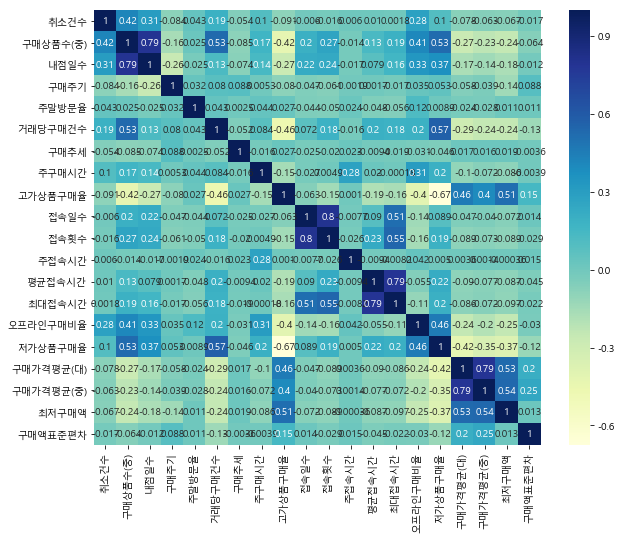

In [33]:
# 상관계수(-1 ~ +1)를 통해 feature 간의 유사성을 파악 
plt.figure(figsize=(10,8))
sns.heatmap(features_2.iloc[:,1:].corr(), annot=True, cmap="YlGnBu")
fig = plt.gcf()
fig.savefig('myfile_1.png', dpi=fig.dpi)

In [31]:
# 상관관계가 높은 (서로 유사한) feature를 제거
features_1 = features.drop(columns=['평균구매액','최대구매액','거래당구매액','구매건수', '구매상품수(소)'
                                  ,'구매상품수(대)','총구매액'])
features_1

,clnt_id,취소건수,구매상품수(중),내점일수,구매주기,주말방문율,거래당구매건수,구매추세,주구매시간,고가상품구매율,접속일수,접속횟수,주접속시간,평균접속시간,최대접속시간,오프라인구매비율,저가상품구매율,구매가격평균(대),구매가격평균(중),최저구매액,구매액표준편차
0,21922,0.0,9,5,16,0.00,2.2,0.27,21,0.00,10,166,13,935.969697,1308.0,0.000000,0.54,2387.967376,3824.086519,900.0,4169.218989
1,39423,0.0,43,19,4,0.09,5.8,0.32,15,0.00,49,1267,17,2522.599842,6223.0,0.156716,0.73,5304.930797,7171.005047,300.0,7014.650752
2,18362,0.0,38,20,4,0.00,5.3,0.22,10,0.00,15,357,10,2167.265537,4324.0,0.102564,0.65,5304.930797,7171.005047,400.0,7960.108000
3,48969,1.0,43,10,8,0.00,8.3,0.16,10,0.01,20,593,16,1676.448567,3313.0,0.300000,0.78,2387.967376,2319.421991,850.0,3616.028234
4,18478,0.0,16,12,6,0.03,1.9,-0.27,10,0.12,5,149,11,1220.536913,1651.0,0.000000,0.28,24838.895349,6032.500000,990.0,54258.879910
5,19163,0.0,47,31,2,0.10,5.6,-0.04,10,0.00,30,321,9,771.623053,3300.0,0.130682,0.53,8661.135334,7171.005047,20.0,4971.358455
6,48190,4.0,23,9,9,0.00,4.4,0.10,18,0.08,9,221,10,2010.167421,3713.0,0.450000,0.52,2387.967376,6547.178831,100.0,5926.892477
7,42454,0.0,32,4,21,0.37,8.5,0.74,19,0.02,6,72,19,558.125000,793.0,0.921569,0.71,2387.967376,2505.267976,660.0,6488.308315
8,29193,16.0,59,31,2,0.00,6.2,1.05,14,0.07,21,560,17,2142.469643,4727.0,0.572072,0.71,2387.967376,2647.851656,550.0,3501.684815
9,65046,0.0,46,22,3,0.06,7.0,0.76,14,0.01,55,1394,14,2019.119799,5482.0,0.000000,0.65,2525.364923,2972.108384,990.0,31615.538883


In [157]:
features = features.merge(cs, how = 'left');features
features.rename(columns = {'clnt_gender':'성별','clnt_age':'나이대'}, inplace = True)
f = df.groupby('clnt_id')['biz_unit'].agg([('주구매플랫폼', 
                                           lambda x: x.value_counts().index[0])]).reset_index()
features = features.merge(f, how = 'left')
f = ld.groupby('clnt_id')['biz_unit'].agg([('주접속플랫폼', 
                                           lambda x: x.value_counts().index[0])]).reset_index()
features = features.merge(f, how = 'left')
f = ld.groupby('clnt_id')['action_type'].agg([('주행동유형', 
                                           lambda x: x.value_counts().index[0])]).reset_index()
features = features.merge(f, how = 'left');features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,취소건수,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,...,접속횟수,주접속시간,평균접속시간,최대접속시간,오프라인구매비율,저가상품구매율,구매가격평균(대),구매가격평균(중),최저구매액,구매액표준편차,성별,나이대,주구매플랫폼,주접속플랫폼,주행동유형
0,21922,79980.0,13.0,6152.0,13900.0,0.0,12,9,7,5,16,0.00,13330.0,2.2,0.27,...,166,13,935.969697,1308.0,0.000000,0.54,2387.967376,3824.086519,900.0,4169.218989,F,50,A03,A03,5
1,39423,676262.0,134.0,5047.0,55600.0,0.0,62,43,20,19,4,0.09,29403.0,5.8,0.32,...,1267,17,2522.599842,6223.0,0.156716,0.73,5304.930797,7171.005047,300.0,7014.650752,F,50,A03,A03,3
2,18362,801200.0,117.0,6848.0,55600.0,0.0,60,38,18,20,4,0.00,36418.0,5.3,0.22,...,357,10,2167.265537,4324.0,0.102564,0.65,5304.930797,7171.005047,400.0,7960.108000,F,40,A03,A03,3
3,48969,371910.0,99.0,3719.0,25800.0,1.0,65,43,17,10,8,0.00,30992.0,8.3,0.16,...,593,16,1676.448567,3313.0,0.300000,0.78,2387.967376,2319.421991,850.0,3616.028234,F,40,A03,A03,5
4,18478,962430.0,32.0,30076.0,209140.0,0.0,21,16,13,12,6,0.03,56614.0,1.9,-0.27,...,149,11,1220.536913,1651.0,0.000000,0.28,24838.895349,6032.500000,990.0,54258.879910,F,30,A03,A03,5
5,19163,1098683.0,176.0,6278.0,31900.0,0.0,88,47,20,31,2,0.10,35441.0,5.6,-0.04,...,321,9,771.623053,3300.0,0.130682,0.53,8661.135334,7171.005047,20.0,4971.358455,M,50,A03,A03,5
6,48190,222570.0,36.0,5564.0,25800.0,4.0,33,23,11,9,9,0.00,24730.0,4.4,0.10,...,221,10,2010.167421,3713.0,0.450000,0.52,2387.967376,6547.178831,100.0,5926.892477,F,30,A03,A03,5
7,42454,287660.0,51.0,5640.0,39900.0,0.0,42,32,20,4,21,0.37,47943.0,8.5,0.74,...,72,19,558.125000,793.0,0.921569,0.71,2387.967376,2505.267976,660.0,6488.308315,F,30,B01,A03,2
8,29193,838305.0,206.0,3776.0,29800.0,16.0,100,59,22,31,2,0.00,23286.0,6.2,1.05,...,560,17,2142.469643,4727.0,0.572072,0.71,2387.967376,2647.851656,550.0,3501.684815,F,50,B01,A03,5
9,65046,1492445.0,161.0,9270.0,398000.0,0.0,69,46,19,22,3,0.06,64889.0,7.0,0.76,...,1394,14,2019.119799,5482.0,0.000000,0.65,2525.364923,2972.108384,990.0,31615.538883,F,30,A03,A03,3


군집 분석을 통한 그룹 분류

In [88]:
X = features_1.iloc[:,1:].apply(lambda x: (x - x.mean()) / x.std(), axis=1) 
X

,취소건수,구매상품수(중),내점일수,구매주기,주말방문율,거래당구매건수,구매추세,주구매시간,고가상품구매율,접속일수,접속횟수,주접속시간,평균접속시간,최대접속시간,오프라인구매비율,저가상품구매율,구매가격평균(대),구매가격평균(중),최저구매액,구매액표준편차
0,-0.533334,-0.526362,-0.529461,-0.520939,-0.533334,-0.531630,-0.533125,-0.517065,-0.533334,-0.525587,-0.404729,-0.523263,0.191790,0.480013,-0.533334,-0.532916,1.316697,2.429303,0.163923,2.696688
1,-0.571124,-0.554728,-0.563879,-0.569599,-0.571089,-0.568912,-0.571002,-0.565404,-0.571124,-0.552440,-0.088027,-0.564642,0.390724,1.801657,-0.571064,-0.570845,1.451604,2.163124,-0.456736,2.103507
2,-0.535283,-0.520643,-0.527578,-0.533742,-0.535283,-0.533241,-0.535199,-0.531431,-0.535283,-0.529504,-0.397743,-0.531431,0.299695,1.130616,-0.535244,-0.535033,1.508537,2.227476,-0.381176,2.531492
3,-0.612213,-0.577591,-0.604794,-0.606442,-0.613037,-0.606195,-0.612905,-0.604794,-0.613029,-0.596550,-0.124204,-0.599848,0.768925,2.117999,-0.612790,-0.612394,1.355458,1.298954,0.087651,2.367797
4,-0.343422,-0.342190,-0.342498,-0.342960,-0.343420,-0.343276,-0.343443,-0.342652,-0.343413,-0.343037,-0.331950,-0.342575,-0.249443,-0.216299,-0.343422,-0.343401,1.569124,0.121068,-0.267194,3.834406
5,-0.483458,-0.465532,-0.471635,-0.482696,-0.483420,-0.481322,-0.483474,-0.479644,-0.483458,-0.472016,-0.361027,-0.480026,-0.189157,0.775178,-0.483408,-0.483256,2.819942,2.251599,-0.475830,1.412643
6,-0.511056,-0.501771,-0.508613,-0.508613,-0.513011,-0.510861,-0.512962,-0.504214,-0.512972,-0.508613,-0.405003,-0.508124,0.469413,1.301634,-0.512791,-0.512757,0.654054,2.686775,-0.464139,2.383624
7,-0.435133,-0.414621,-0.432569,-0.421672,-0.434896,-0.429685,-0.434659,-0.422954,-0.435120,-0.431287,-0.388982,-0.422954,-0.077381,0.073171,-0.434542,-0.434678,1.095528,1.170716,-0.012080,3.723801
8,-0.574011,-0.543848,-0.563489,-0.583832,-0.585235,-0.580886,-0.584499,-0.575414,-0.585186,-0.570504,-0.192403,-0.573310,0.917678,2.730691,-0.584834,-0.584737,1.089891,1.272197,-0.199418,1.871149
9,-0.335137,-0.328599,-0.332010,-0.334711,-0.335129,-0.334142,-0.335029,-0.333147,-0.335136,-0.327320,-0.137014,-0.333147,-0.048168,0.443997,-0.335137,-0.335045,0.023783,0.087276,-0.194432,4.158248


In [89]:
# 군집 수에 따른 SSE(군집내 오차제곱합)와 Silhouette score(군집간 분리도 - 군집내 응집도) 계산

wss = []
sis = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    wss = np.append(wss, kmeans.inertia_)
    sis = np.append(sis, silhouette_score(X, kmeans.labels_))

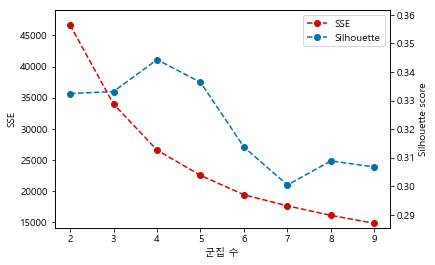

In [90]:
# 군집 수에 따른 SSE와 Silhouette score 시각화
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

line1 = ax1.plot(np.arange(2,10), wss, 'ro--', label='SSE')
line2 = ax2.plot(np.arange(2,10), sis, 'bo--', label='Silhouette') 

ax1.set_ylim(wss.min()*0.95, wss.max()*1.05)
ax2.set_ylim(sis.min()*0.95, sis.max()*1.05)

ax1.set_xlabel('군집 수')
ax1.set_ylabel('SSE')
ax2.set_ylabel('Silhouette score')

lines = line1 + line2
labels = [l.get_label() for l in lines]

plt.legend(lines, labels)
plt.show()

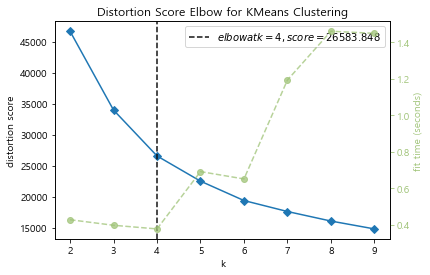

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000002C047BC58D0>,
         k=None, locate_elbow=True, metric='distortion', model=None,
         timings=True)

In [91]:
from yellowbrick.cluster.elbow import kelbow_visualizer

kelbow_visualizer(KMeans(random_state=0), X, k=(2,10))

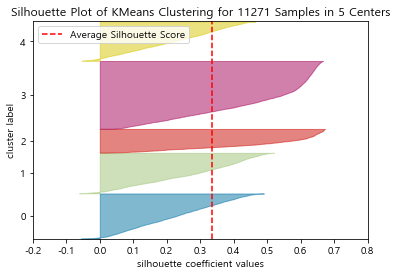

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000002C04A20A240>,
           colors='yellowbrick', is_fitted='auto', model=None)

In [108]:
# Silhouette diagram
# 높이: 군집의 크기, 넓이: 각 군집에 포함된 샘플의 정렬된 실루엣 계수, 점선: 실루엣 점수  
# 각 군집의 샘플 대부분이 실루엣 점수를 초과하면 군집의 수가 적당한 것으로 판단

#from yellowbrick.cluster import silhouette_visualizer

silhouette_visualizer(KMeans(5, random_state=0), X, colors='yellowbrick')

In [57]:
# sns 설정이 바뀌었기 때문에 원래로 되돌린다.
sns.reset_defaults()
%matplotlib inline

# Yellowbrick은 영문 폰트를 사용하여 시각화를 하기 떄문에 다시 한글 폰트로 변경해야 한다.
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)

In [98]:
best_k = 5

In [99]:
kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [100]:
features_1['세그먼트'] = kmeans.labels_
features_1

,clnt_id,취소건수,구매상품수(중),내점일수,구매주기,주말방문율,거래당구매건수,구매추세,주구매시간,고가상품구매율,접속일수,접속횟수,주접속시간,평균접속시간,최대접속시간,오프라인구매비율,저가상품구매율,구매가격평균(대),구매가격평균(중),최저구매액,구매액표준편차,세그먼트
0,21922,0.0,9,5,16,0.00,2.2,0.27,21,0.00,10,166,13,935.969697,1308.0,0.000000,0.54,2387.967376,3824.086519,900.0,4169.218989,0
1,39423,0.0,43,19,4,0.09,5.8,0.32,15,0.00,49,1267,17,2522.599842,6223.0,0.156716,0.73,5304.930797,7171.005047,300.0,7014.650752,1
2,18362,0.0,38,20,4,0.00,5.3,0.22,10,0.00,15,357,10,2167.265537,4324.0,0.102564,0.65,5304.930797,7171.005047,400.0,7960.108000,0
3,48969,1.0,43,10,8,0.00,8.3,0.16,10,0.01,20,593,16,1676.448567,3313.0,0.300000,0.78,2387.967376,2319.421991,850.0,3616.028234,1
4,18478,0.0,16,12,6,0.03,1.9,-0.27,10,0.12,5,149,11,1220.536913,1651.0,0.000000,0.28,24838.895349,6032.500000,990.0,54258.879910,3
5,19163,0.0,47,31,2,0.10,5.6,-0.04,10,0.00,30,321,9,771.623053,3300.0,0.130682,0.53,8661.135334,7171.005047,20.0,4971.358455,4
6,48190,4.0,23,9,9,0.00,4.4,0.10,18,0.08,9,221,10,2010.167421,3713.0,0.450000,0.52,2387.967376,6547.178831,100.0,5926.892477,0
7,42454,0.0,32,4,21,0.37,8.5,0.74,19,0.02,6,72,19,558.125000,793.0,0.921569,0.71,2387.967376,2505.267976,660.0,6488.308315,3
8,29193,16.0,59,31,2,0.00,6.2,1.05,14,0.07,21,560,17,2142.469643,4727.0,0.572072,0.71,2387.967376,2647.851656,550.0,3501.684815,1
9,65046,0.0,46,22,3,0.06,7.0,0.76,14,0.01,55,1394,14,2019.119799,5482.0,0.000000,0.65,2525.364923,2972.108384,990.0,31615.538883,3


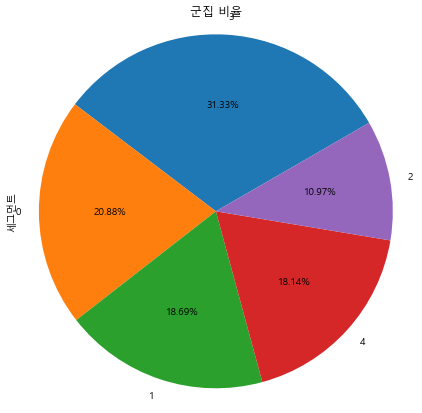

In [101]:
plt.figure(figsize=(6,6))
features_1.세그먼트.value_counts().plot.pie(autopct='%.2f%%', figsize=(7,7), 
                                      startangle=30, legend=False)
plt.title("군집 비율")
plt.axis('equal')
plt.show()

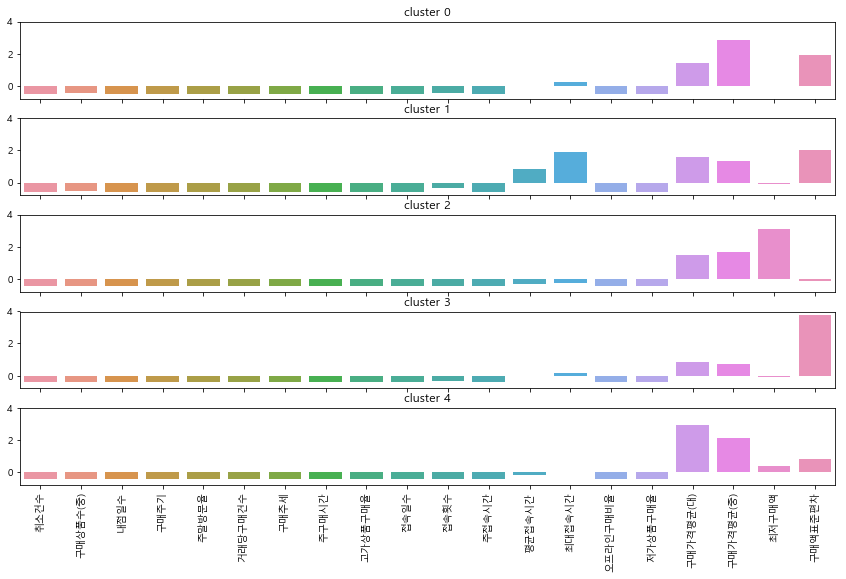

In [102]:
fig, ax = plt.subplots(best_k, 1, figsize=(12,7), sharex=True, sharey=True)
ax = ax.ravel()
plt.tight_layout() # 자동으로 레이아웃 조정
#plt.subplots_adjust(hspace=0.2) # subplot간의 너비 간격 조절

for i in range(kmeans.n_clusters):
    ax[i].set_title('cluster %d' % i)
#    ax[i].bar(np.arange(X.columns.size), kmeans.cluster_centers_[i])
    sns.barplot(np.arange(X.columns.size), kmeans.cluster_centers_[i], ax=ax[i])
    ax[i].set_xticks(np.arange(X.columns.size))
    ax[i].set_xticklabels(X.columns, rotation=90)

In [106]:
features_1.groupby('세그먼트').median().T

세그먼트,0,1,2,3,4
clnt_id,35971.000000,37352.000000,36708.000000,35989.000000,35018.500000
총구매액,257010.000000,257220.000000,72505.000000,427308.000000,105440.000000
구매건수,34.000000,59.000000,1.000000,43.000000,8.000000
평균구매액,5952.000000,4282.000000,49000.000000,8343.000000,9900.000000
최대구매액,29900.000000,19900.000000,50615.000000,78000.000000,27390.000000
취소건수,0.000000,0.000000,0.000000,0.000000,0.000000
구매상품수(소),24.000000,37.000000,1.000000,30.000000,6.000000
구매상품수(중),19.000000,28.000000,1.000000,24.000000,5.000000
구매상품수(대),12.000000,14.000000,1.000000,14.000000,4.000000
내점일수,6.000000,8.000000,1.000000,8.000000,3.000000


In [104]:
f = features_1[['clnt_id','세그먼트']];f

,clnt_id,세그먼트
0,21922,0
1,39423,1
2,18362,0
3,48969,1
4,18478,3
5,19163,4
6,48190,0
7,42454,3
8,29193,1
9,65046,3


In [105]:
features = features.merge(f);features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,취소건수,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,...,주접속시간,평균접속시간,최대접속시간,오프라인구매비율,저가상품구매율,구매가격평균(대),구매가격평균(중),최저구매액,구매액표준편차,성별,나이대,주구매플랫폼,주접속플랫폼,주행동유형,세그먼트
0,21922,79980.0,13.0,6152.0,13900.0,0.0,12,9,7,5,16,0.00,13330.0,2.2,0.27,...,13,935.969697,1308.0,0.000000,0.54,2387.967376,3824.086519,900.0,4169.218989,F,50,A03,A03,5,0
1,39423,676262.0,134.0,5047.0,55600.0,0.0,62,43,20,19,4,0.09,29403.0,5.8,0.32,...,17,2522.599842,6223.0,0.156716,0.73,5304.930797,7171.005047,300.0,7014.650752,F,50,A03,A03,3,1
2,18362,801200.0,117.0,6848.0,55600.0,0.0,60,38,18,20,4,0.00,36418.0,5.3,0.22,...,10,2167.265537,4324.0,0.102564,0.65,5304.930797,7171.005047,400.0,7960.108000,F,40,A03,A03,3,0
3,48969,371910.0,99.0,3719.0,25800.0,1.0,65,43,17,10,8,0.00,30992.0,8.3,0.16,...,16,1676.448567,3313.0,0.300000,0.78,2387.967376,2319.421991,850.0,3616.028234,F,40,A03,A03,5,1
4,18478,962430.0,32.0,30076.0,209140.0,0.0,21,16,13,12,6,0.03,56614.0,1.9,-0.27,...,11,1220.536913,1651.0,0.000000,0.28,24838.895349,6032.500000,990.0,54258.879910,F,30,A03,A03,5,3
5,19163,1098683.0,176.0,6278.0,31900.0,0.0,88,47,20,31,2,0.10,35441.0,5.6,-0.04,...,9,771.623053,3300.0,0.130682,0.53,8661.135334,7171.005047,20.0,4971.358455,M,50,A03,A03,5,4
6,48190,222570.0,36.0,5564.0,25800.0,4.0,33,23,11,9,9,0.00,24730.0,4.4,0.10,...,10,2010.167421,3713.0,0.450000,0.52,2387.967376,6547.178831,100.0,5926.892477,F,30,A03,A03,5,0
7,42454,287660.0,51.0,5640.0,39900.0,0.0,42,32,20,4,21,0.37,47943.0,8.5,0.74,...,19,558.125000,793.0,0.921569,0.71,2387.967376,2505.267976,660.0,6488.308315,F,30,B01,A03,2,3
8,29193,838305.0,206.0,3776.0,29800.0,16.0,100,59,22,31,2,0.00,23286.0,6.2,1.05,...,17,2142.469643,4727.0,0.572072,0.71,2387.967376,2647.851656,550.0,3501.684815,F,50,B01,A03,5,1
9,65046,1492445.0,161.0,9270.0,398000.0,0.0,69,46,19,22,3,0.06,64889.0,7.0,0.76,...,14,2019.119799,5482.0,0.000000,0.65,2525.364923,2972.108384,990.0,31615.538883,F,30,A03,A03,3,3


In [77]:
group = {0 : 'Potential Main', 1 : 'Cheap & Many', 2 : 'Fashion & Cosmetics', 3 : 'Main', 4 : 'Useful'}

In [79]:
features['세그먼트'] = features.세그먼트.apply(lambda x: group.get(x))

In [112]:
m = features.query('세그먼트 == "Main"')
pm = features.query('세그먼트 == "Potential Main"')
u = features.query('세그먼트 == "Uesful"')
cm = features.query('세그먼트 == "Cheap & Many"')
fc = features.query('세그먼트 == "Fashion & Cosmetics"')

In [10]:
df = df.merge(features[['clnt_id','세그먼트']], how = 'right');df

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3,price,세그먼트
0,21922,104999,3,A03,182,2019-09-20,12:41,10900.0,1,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups,10900.0,0
1,21922,104999,4,A03,178,2019-09-20,12:41,9900.0,1,F,50,Chilled Foods,Chilled Instant Foods,Chilled Noodles,9900.0,0
2,21922,102455,3,A03,1584,2019-09-18,21:07,2990.0,1,F,50,Vegetables,Leaf Vegetables,Onions,2990.0,0
3,21922,102455,1,A03,943,2019-09-18,21:07,11160.0,1,F,50,Meats,Domestic Beefs,Domestic Beefs - Rounds,11160.0,0
4,21922,102455,5,A03,1566,2019-09-18,21:07,3890.0,1,F,50,Vegetables,Fruit Vegetables,Cucumbers,3890.0,0
5,21922,102455,6,A03,410,2019-09-18,21:07,8900.0,1,F,50,Dried Sea Foods,Processed Seaweeds,Seasoned Sliced Dried Lavers,8900.0,0
6,21922,90418,3,A03,933,2019-09-02,13:39,6990.0,1,F,50,Meats,Chickens,Chickins for Braised Spicy Soups,6990.0,0
7,21922,90411,2,A03,348,2019-09-02,13:29,2490.0,1,F,50,Dairy Products,Milk,Functional Milk,2490.0,0
8,21922,51249,1,A03,348,2019-07-16,23:21,2890.0,1,F,50,Dairy Products,Milk,Functional Milk,2890.0,0
9,21922,39789,1,A03,1581,2019-07-02,02:24,3780.0,2,F,50,Vegetables,Leaf Vegetables,Jumbo Spring Onions,1890.0,0


코사인 유사도를 통한 그룹 별 상품 추천

In [180]:
# 코사인 유사도
from sklearn.metrics.pairwise import cosine_similarity

In [348]:
# 행은 고객ID, 열은 상품명으로 pivoting 수행. 구매가 없는 값(NaN)은 모두 0으로 변환
ratings_matrix = pd.pivot_table(df.query('세그먼트 == 4'), index='clnt_id', columns='clac_nm1', values='pd_c', 
                                aggfunc=lambda x: 1 if len(x) >= 1 else 0, fill_value=0)

print(ratings_matrix.shape)
ratings_matrix

(2044, 60)


clac_nm1,Automotive Products,Baby Foods,Ball Game / Field Sports,Bedding / Handicraft,Beverages,Birth Supplies / Baby Products,Books / Records / Instruments,Canned / Jarred Foods,Cell Phones / Accessories,Chilled Foods,Cleaning / Laundry / Bathroom Accessories,Coffee / Tea,Computers,Cooked Foods,Cosmetics / Beauty Care,...,Snack Foods,Spices / Seasonings,Sport Fashion,Stationary / Office Supplies,Substitute Foods,Tableware / Cooking Utensils,Tenants / Restaurants,Tobacco,Tools / Safety Supplies,Toy,Travel / Leisure Services,Underwear / Socks and Hosiery / Homewear,Vegetables,Video / Audio System Electronics,Women's Clothing
clnt_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
29,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,...,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0
57,0,0,0,1,0,0,0,0,0,0,1,1,0,1,1,...,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1
92,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
172,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
185,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1
189,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
211,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
214,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
277,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [41]:
# 유사도가 가장 높은 이웃의 수 설정 (분석가가 임의로 결정)
K = 50

In [349]:
# cosine_similarity()는 행을 기준으로(즉, 고객 간) 유사도를 계산
user_sim = cosine_similarity(ratings_matrix, ratings_matrix)

# cosine_similarity()로 반환된 numpy 행렬에 상품명을 매핑하기 위해 DataFrame으로 변환
# 행과 열이 동일한 데이터프레임이 생성됨.
user_sim = pd.DataFrame(user_sim, ratings_matrix.index, ratings_matrix.index)

# 다음 단계에서 사용하기 위해 의도적으로 대각선 값을 1에서 2(코사인 유사도 최대값 1보다 크게)로 변경
# np.fill_diagonal() 사용
np.fill_diagonal(user_sim.values, 2)

print(user_sim.shape)
user_sim

(2044, 2044)


clnt_id,29,57,92,172,185,189,211,214,277,377,385,475,548,577,583,...,71958,71959,71996,72005,72023,72067,72125,72131,72133,72193,72198,72199,72221,72284,72297
clnt_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
29,2.000000,0.660578,0.000000,0.000000,0.326599,0.000000,0.000000,0.000000,0.000000,0.387298,0.000000,0.000000,0.000000,0.456435,0.365148,...,0.688847,0.000000,0.622799,0.000000,0.000000,0.000000,0.000000,0.258199,0.000000,0.751469,0.000000,0.737865,0.394405,0.710819,0.585540
57,0.660578,2.000000,0.213201,0.000000,0.539360,0.369274,0.000000,0.150756,0.301511,0.319801,0.213201,0.174078,0.246183,0.452267,0.150756,...,0.568796,0.150756,0.642824,0.000000,0.150756,0.150756,0.000000,0.213201,0.213201,0.620505,0.213201,0.609272,0.558291,0.684762,0.483494
92,0.000000,0.213201,2.000000,0.000000,0.000000,0.577350,0.000000,0.000000,0.707107,0.000000,0.000000,0.408248,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.218218,0.000000,0.000000
172,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
185,0.326599,0.539360,0.000000,0.000000,2.000000,0.182574,0.000000,0.223607,0.223607,0.000000,0.316228,0.129099,0.365148,0.335410,0.447214,...,0.306786,0.223607,0.381385,0.000000,0.223607,0.000000,0.000000,0.000000,0.316228,0.460179,0.316228,0.387298,0.414039,0.435286,0.239046
189,0.000000,0.369274,0.577350,0.000000,0.182574,2.000000,0.000000,0.000000,0.816497,0.000000,0.577350,0.471405,0.333333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.408248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.251976,0.132453,0.000000
211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.288675,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.154303,0.000000,0.000000
214,0.000000,0.150756,0.000000,0.000000,0.223607,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
277,0.000000,0.301511,0.707107,0.000000,0.223607,0.816497,0.000000,0.000000,2.000000,0.000000,0.707107,0.577350,0.408248,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.308607,0.162221,0.000000


In [350]:
# 각 고객마다 K-nearest neighbors 생성. 다음단계에서 사용하기 위해 의도적으로 자기 자신을 가장 가까운 이웃으로 설정(K+1개) 
# 행은 고객, 열은 K개의 이웃인 데이터 프레임이 만들어짐. 
knn = user_sim.apply(lambda x,k: x.sort_values(ascending=False).index[:k+1], args=(K,)).T
knn

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
clnt_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
29,29,29884,25661,1367,36829,45943,13995,41992,62231,12105,49372,25617,28239,11508,45668,...,11395,67079,25479,45171,52660,61116,24645,56824,54312,52706,27202,3929,49295,10402,1724
57,57,70342,2609,54312,25617,69769,8929,53873,47611,67053,70416,40696,9589,1208,37043,...,11508,27332,29057,17895,4500,63742,26270,72284,39446,59201,51472,67063,67079,41503,46376
92,92,37375,24544,2927,9280,26286,26205,37409,9338,57037,67932,24882,10098,56844,39431,...,65235,61894,67435,61020,67131,51089,52287,2313,52034,63468,48673,65409,5797,2112,3629
172,172,29938,33424,22971,18022,26771,64942,40593,54614,49339,65035,21841,44880,28608,11716,...,71638,22693,31363,32631,8030,17293,38769,53240,51442,1591,22419,44079,61513,62132,54111
185,185,6982,21791,57837,16649,27532,64919,36044,44267,30990,4438,66230,39446,49900,11509,...,29057,10002,66096,4646,32756,54761,13069,64035,13727,10920,23238,49345,71460,22578,24475
189,189,60755,5929,28056,31072,28409,2967,9468,61265,51821,69073,36029,65409,35012,19502,...,21885,13500,47227,2857,29923,47162,1336,29972,71135,55686,55185,1112,65618,59251,41912
211,211,3216,50406,8007,43745,991,66801,66805,22114,56024,47509,17631,47576,3696,69451,...,2634,8194,2698,48379,29676,40829,8002,68373,35489,44235,8330,3424,61269,6782,13161
214,214,3770,11168,66211,66993,37709,22134,6902,67610,62276,13573,5803,2724,13473,25322,...,6526,58926,29972,71672,40006,56134,9075,17533,15005,27532,7896,17589,58973,63582,55624
277,277,35012,10847,34169,59699,19502,2967,70067,62284,61265,9468,9626,69073,36029,65409,...,189,29972,29923,23527,65618,71591,24888,21885,4067,64187,9302,54584,9338,12265,9734


In [231]:
# 추천할 상품수 설정 (분석가가 임의로 결정)
N = 10

In [351]:
# 추천 리스트에서 제외하기 위해 이미 구매한 상품 목록 작성
purchased_list = df.query('세그먼트 == 4').groupby('clnt_id')['clac_nm1'].unique()
purchased_list

clnt_id
29       [Vegetables, Fruits, Chilled Foods, Substitute...
57       [Vegetables, Dried Sea Foods, Meats, Substitut...
92                                   [Fashion Accessories]
172                            [Home / Kitchen Appliances]
185      [Personal Care, Snack Foods, Beverages, Kitche...
189      [Bedding / Handicraft, Women's Clothing, Fashi...
211                       [Sport Fashion, Seasonal Sports]
214                            [Furniture, Kids' Clothing]
277                [Women's Clothing, Fashion Accessories]
377                 [Fruits, Meats, Vegetables, Sea Foods]
385                                     [Women's Clothing]
475      [Women's Clothing, Sport Fashion, Fashion Acce...
548      [Cosmetics / Beauty Care, Health Care, Women's...
577      [Beverages, Fruits, Vegetables, Meats, Snack F...
583                               [Snack Foods, Beverages]
                               ...                        
71958    [Dried Sea Foods, Snack Foods, Meats, C

In [352]:
# 이미 구매한 상품을 제외하고 유사집단에서 가장 많이 구매한 N개의 상품을 추천 
def top_n(x, n):
    # 고객이 구매했던 상품을 뽑아내는 과정: x[0]에는 고객id가 있음 (이를 위해 의도적으로 이웃의 수를 K+1로 했던 것)
    purchased = purchased_list.filter(items=[x[0]]).iloc[0]
    # 위 고객의 이웃들이 가장 많이 산 상품을 뽑아내는 과정: x[1:]에는 이웃들의 id가 들어가 있음. 
    candidate = ratings_matrix.filter(items=x[1:], axis=0).sum().sort_values(ascending=False).index.to_list()
    # 위 이웃들이 가장 많이 산 상품에서 이미 구매했던 상품을 제외하고 N개를 추천
    return [item for item in candidate if item not in purchased][:n]

# knn의 행, 즉 고객별로 top_n을 고객 수만큼 호출 
# 고객ID와 추천상품 두 개의 컬럼이 생기는데, 추천상품 컬럼에는 리스트 형태로 상품이 저장됨. 
recommend_list_4 = knn.apply(top_n, args=(N,), axis=1).reset_index().rename(columns={0:'recommend_items'})
recommend_list_4

,clnt_id,recommend_items
0,29,"[Frozen Foods, Canned / Jarred Foods, Sea Food..."
1,57,"[Chilled Foods, Dairy Products, Beverages, Sea..."
2,92,"[Personal Care, Cosmetics / Beauty Care, Dairy..."
3,172,"[Cosmetics / Beauty Care, Fashion Accessories,..."
4,185,"[Frozen Foods, Fruits, Dairy Products, Vegetab..."
5,189,"[Sport Fashion, Cosmetics / Beauty Care, Healt..."
6,211,"[Women's Clothing, Detergents / Hygiene Goods,..."
7,214,"[Women's Clothing, Toy, Cosmetics / Beauty Car..."
8,277,"[Sport Fashion, Cosmetics / Beauty Care, Healt..."
9,377,"[Chilled Foods, Substitute Foods, Dairy Produc..."


In [18]:
def lst_dict(x):
    b = []
    j = len(x)
    for i in x:
        b.append((i,j))
        j -= 1
    return dict(b)

In [353]:
recommend_list_4['recommend_items'] = recommend_list_4['recommend_items'].apply(lst_dict)

In [354]:
recommend_list_4

,clnt_id,recommend_items
0,29,"{'Frozen Foods': 10, 'Canned / Jarred Foods': ..."
1,57,"{'Chilled Foods': 10, 'Dairy Products': 9, 'Be..."
2,92,"{'Personal Care': 10, 'Cosmetics / Beauty Care..."
3,172,"{'Cosmetics / Beauty Care': 10, 'Fashion Acces..."
4,185,"{'Frozen Foods': 10, 'Fruits': 9, 'Dairy Produ..."
5,189,"{'Sport Fashion': 10, 'Cosmetics / Beauty Care..."
6,211,"{'Women's Clothing': 10, 'Detergents / Hygiene..."
7,214,"{'Women's Clothing': 10, 'Toy': 9, 'Cosmetics ..."
8,277,"{'Sport Fashion': 10, 'Cosmetics / Beauty Care..."
9,377,"{'Chilled Foods': 10, 'Substitute Foods': 9, '..."


In [355]:
# from collections import Counter
j = {}
for i in recommend_list_4.recommend_items:
    A = Counter(i)
    B = Counter(j)
    j = A+B
a = sorted(j.items(), reverse=True, key=lambda item: item[1])
recommend_4 = a[:10]
recommend_4 = [i for i,j in recommend_4]

In [356]:
recommend_4 = pd.DataFrame(recommend_4)

In [357]:
recommend = pd.concat([recommend, recommend_4], axis = 1)

In [18]:
recommend['Potential Main'] = recommend.iloc[:,0]
recommend['Cheap & Many'] = recommend.iloc[:,1]
recommend['Fashion & Cosmetics'] = recommend.iloc[:,2]
recommend['Main'] = recommend.iloc[:,3]
recommend['Useful'] = recommend.iloc[:,4]

In [23]:
del recommend[0]

In [24]:
recommend

,Potential Main,Cheap & Many,Fashion & Cosmetics,Main,Useful
0,Personal Care,Canned / Jarred Foods,Women's Clothing,Detergents / Hygiene Goods,Cosmetics / Beauty Care
1,Canned / Jarred Foods,Sea Foods,Cosmetics / Beauty Care,Canned / Jarred Foods,Frozen Foods
2,Detergents / Hygiene Goods,Detergents / Hygiene Goods,Health / Fitness Training,Dried Sea Foods,Fruits
3,Dried Sea Foods,Dried Sea Foods,Grains,Frozen Foods,Women's Clothing
4,Sea Foods,Personal Care,Fashion Accessories,Beverages,Meats
5,Snack Foods,Coffee / Tea,Gift Certificates / Cards,Spices / Seasonings,Detergents / Hygiene Goods
6,Spices / Seasonings,Grains,Gardening / Pets,Sea Foods,Chilled Foods
7,Fruits,Cooked Foods,Video / Audio System Electronics,Snack Foods,Personal Care
8,Beverages,Kitchenware,Meats,Personal Care,Dairy Products
9,Frozen Foods,Liquors / Alcoholic Beverages,Health Care,Fruits,Snack Foods


시각화를 통한 그룹 별 서비스 추천

In [188]:
features.groupby('세그먼트').mean().T

세그먼트,Cheap & Many,Fashion & Cosmetics,Main,Potential Main,Useful
clnt_id,37254.043664,36513.521845,36374.509204,36223.277943,35038.352740
총구매액,354163.474846,135149.086570,705913.750496,436161.419890,219054.719912
구매건수,79.742288,1.700647,66.246389,53.981300,22.016145
평균구매액,4546.082107,86891.577670,20740.923818,20454.977901,24284.486791
최대구매액,24732.036308,91341.053398,166787.900595,62426.038674,46258.237035
취소건수,0.574751,0.000000,0.845936,0.647259,0.261252
구매상품수(소),42.439013,1.347087,38.004248,31.552911,13.690313
구매상품수(중),28.946369,1.305016,27.043614,22.312792,10.584638
구매상품수(대),13.954912,1.260518,14.350326,11.856779,6.560665
내점일수,11.220693,1.321197,10.921835,8.776881,4.835616


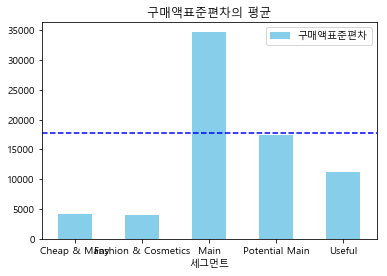

In [173]:
features[['세그먼트','구매액표준편차']].groupby(['세그먼트']).mean().plot.bar(rot = 0, color='skyblue')
plt.title('구매액표준편차의 평균')
plt.axhline(y=np.mean(features.구매액표준편차), color = 'blue', ls = '--')
plt.show()

C:\Users\rltjq\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\rltjq\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


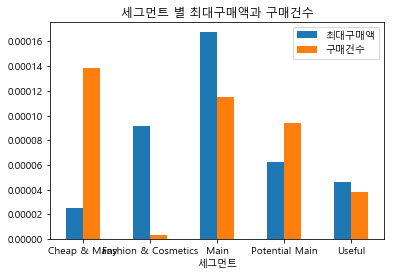

In [177]:
a = features[['세그먼트','최대구매액', '구매건수']]
a['최대구매액'] = a['최대구매액'] / sum(a['최대구매액'])
a['구매건수'] = a['구매건수'] / sum(a['구매건수'])
a.groupby('세그먼트').mean().plot.bar(rot=0)
plt.title('세그먼트 별 최대구매액과 구매건수')
plt.legend(loc = 'upper right')
plt.show()

C:\Users\rltjq\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\rltjq\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\rltjq\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

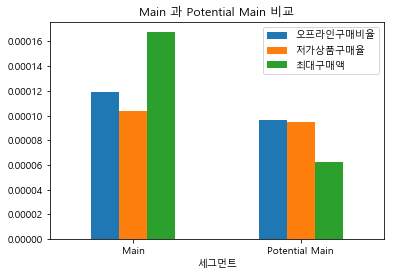

In [111]:
a = features[['세그먼트','오프라인구매비율','저가상품구매율', '최대구매액']]
a['최대구매액'] = a['최대구매액'] / sum(a['최대구매액'])
a['저가상품구매율'] = a['저가상품구매율'] / sum(a['저가상품구매율'])
a['오프라인구매비율'] = a['오프라인구매비율'] / sum(a['오프라인구매비율'])
a.query('세그먼트 == "Main" or 세그먼트 == "Potential Main"').groupby('세그먼트').mean().plot.bar(rot=0)
plt.title('Main 과 Potential Main 비교')
plt.legend(loc = 'upper right')
plt.show()

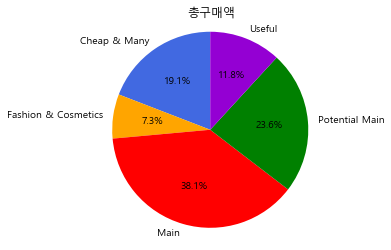

In [184]:
labels = ['Cheap & Many', 'Fashion & Cosmetics', 'Main', 'Potential Main', 'Useful']
sizes = features.groupby('세그먼트')['총구매액'].agg(lambda x : sum(x)/len(x)).reset_index()
color = ['royalblue','orange','r','green','darkviolet']
sizes = sizes['총구매액']/sum( sizes['총구매액'])
plt.title("총구매액")
plt.pie(sizes,labels = labels, colors = color,
        autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()

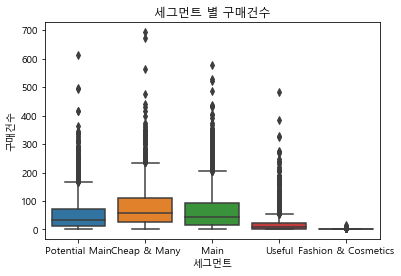

In [185]:
sns.boxplot(x='세그먼트',y='구매건수', data=features)
plt.title('세그먼트 별 구매건수')
plt.show()

C:\Users\rltjq\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\rltjq\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


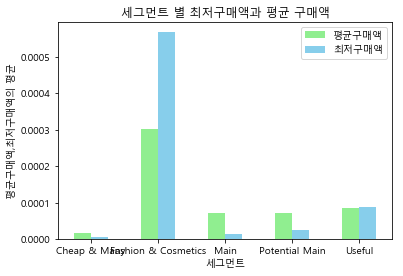

In [186]:
a = features[['세그먼트','평균구매액', '최저구매액']]
a['최저구매액'] = a['최저구매액'] / sum(a['최저구매액'])
a['평균구매액'] = a['평균구매액'] / sum(a['평균구매액'])
a.groupby('세그먼트').mean().plot.bar(rot=0, color = ['lightgreen','skyblue'])
plt.title('세그먼트 별 최저구매액과 평균 구매액')
plt.legend(loc = 'upper right')
plt.ylabel('평균구매액,최저구매액의 평균')
plt.show()

C:\Users\rltjq\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\rltjq\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


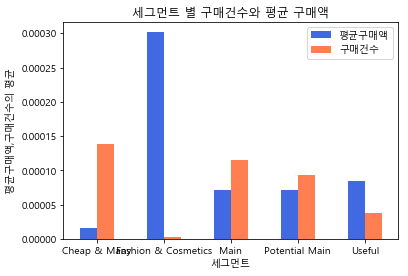

In [187]:
a = features[['세그먼트','평균구매액', '구매건수']]
a['구매건수'] = a['구매건수'] / sum(a['구매건수'])
a['평균구매액'] = a['평균구매액'] / sum(a['평균구매액'])
a.groupby('세그먼트').mean().plot.bar(rot=0, color = ['royalblue','coral'])
plt.title('세그먼트 별 구매건수와 평균 구매액')
plt.legend(loc = 'upper right')
plt.ylabel('평균구매액,구매건수의 평균')
plt.show()